<a href="https://www.kaggle.com/code/jhtkoo0426/house-price-predictions-ft-catboostregressor?scriptVersionId=150684755" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

In [1]:
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Models
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor

# Load datasets

In [2]:
train_ds = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_ds  = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
X = train_ds.drop(columns=['Id', 'SalePrice'], axis=1)
y = train_ds['SalePrice']

# Exploring the dataset

## Dataset information
First, let's see what data types the dataset consists of.

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

From the dataset information, we observe that there are:
- 36 columns containing **numerical** data; and
- 43 columns containing **categorical or object** data

Since the handling of these two types of data differs, we will segregate them accordingly.

In [5]:
numeric_features = X.select_dtypes(include=['number'])
categorical_features = X.select_dtypes(include=['object'])
categorical_features.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

<Axes: >

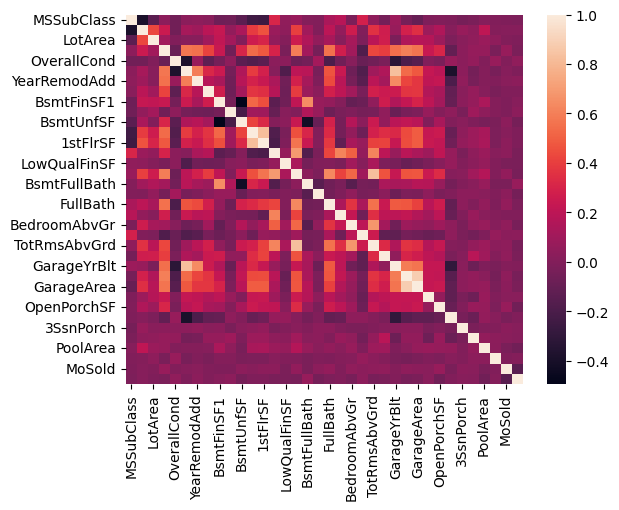

In [6]:
sns.heatmap(numeric_features.corr())

## Null columns
Let's take a look at which columns contain `NULL` values. This will provide us a reference point when we construct a pipeline class to process `NULL` values.

In [7]:
feature_contains_null = X.isna().sum().sort_values(ascending=False)
feature_contains_null[feature_contains_null > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageQual        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

# Data preprocessing
Deal with `NULL` values according to the data description and treating special cases.

In [8]:
class NullProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Fill categorical NA values based on data description
        for col in ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'MiscFeature']:
            X[col] = X[col].fillna('NA')
        
        for col in ['MasVnrType']:
            X[col] = X[col].fillna('None')
        
        for col in ['MasVnrArea', 'LotFrontage']:
            X[col] = X[col].fillna(0)
            
        # Special cases - we want to fill NULL values in these columns with special values instead.
        X['Electrical'] = X['Electrical'].fillna('SBrkr')
        return X

# Feature Engineering

In [9]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['AvgRoomArea'] = X['GrLivArea'] / (X['TotRmsAbvGrd'] + X['FullBath'] + X['HalfBath'] + X['KitchenAbvGr'])
        X['BathroomCnt'] = X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath'])
        X["TotalArea"] = X["GrLivArea"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["TotalBsmtSF"] + X["MasVnrArea"]
        X["Age"] = pd.to_numeric(X["YrSold"]) - pd.to_numeric(X["YearBuilt"])
        X["Renovate"] = pd.to_numeric(X["YearRemodAdd"]) - pd.to_numeric(X["YearBuilt"])
        return X

# Create pipeline

In [10]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('column_dropper', 'drop', ['PoolQC', 'GarageYrBlt']),
    ('num', numeric_transformer, numeric_features.columns),
    ('cat', categorical_transformer, categorical_features.columns),
])

Combine preprocessing with the model in a single pipeline

In [11]:
pipeline = Pipeline(steps=[
    ('null_processor', NullProcessor()),
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('classifier', CatBoostRegressor()),
])

Fit the pipeline on the training data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
pipeline.fit(X_train, y_train)

Learning rate set to 0.04196
0:	learn: 75267.2537229	total: 58.4ms	remaining: 58.4s
1:	learn: 73314.5967170	total: 61.5ms	remaining: 30.7s
2:	learn: 71312.0158437	total: 64.5ms	remaining: 21.4s
3:	learn: 69494.6720000	total: 67.4ms	remaining: 16.8s
4:	learn: 67930.0340906	total: 70.3ms	remaining: 14s
5:	learn: 66435.6236191	total: 73.2ms	remaining: 12.1s
6:	learn: 64808.2249091	total: 76.2ms	remaining: 10.8s
7:	learn: 63248.2627875	total: 79.1ms	remaining: 9.81s
8:	learn: 61639.2337169	total: 82ms	remaining: 9.03s
9:	learn: 60337.0251830	total: 85ms	remaining: 8.41s
10:	learn: 58991.5221486	total: 87.9ms	remaining: 7.9s
11:	learn: 57708.5055058	total: 90.9ms	remaining: 7.48s
12:	learn: 56395.9472036	total: 93.8ms	remaining: 7.12s
13:	learn: 55180.7413436	total: 96.8ms	remaining: 6.82s
14:	learn: 53981.4511019	total: 99.8ms	remaining: 6.56s
15:	learn: 52820.7150416	total: 103ms	remaining: 6.33s
16:	learn: 51752.1298587	total: 106ms	remaining: 6.12s
17:	learn: 50755.0189530	total: 109ms	

Pipeline(steps=[('null_processor', NullProcessor()),
                ('feature_engineer', FeatureEngineer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('column_dropper', 'drop',
                                                  ['PoolQC', 'GarageYrBlt']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBui...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('classifier',
                 <catboost.core.CatBoostRegressor object at 0x7deae2198970>)])

In [14]:
train_predictions = pipeline.predict(X_test)

In [15]:
rmse_score = np.sqrt(mean_squared_error(train_predictions, y_test))
rmse_score

25670.054595006026

# Making predictions & submission file

Make predictions on the testing data

In [16]:
submission_df = test_ds[['Id']]
test_ds = test_ds.drop(columns=['Id'])

In [17]:
predicted_prices = pipeline.predict(test_ds)

In [18]:
submission_df['SalePrice'] = predicted_prices
submission_df = submission_df.set_index('Id')
submission = submission_df.to_csv("submission.csv", encoding='utf-8')

In [19]:
!head submission.csv

Id,SalePrice
1461,127766.4052036793
1462,163225.20113847777
1463,182491.4251405694
1464,187442.87020989266
1465,184642.3965736958
1466,172747.78912799383
1467,164967.84728021058
1468,163159.18611728432
1469,187364.59546800042
